In [192]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cross_validation import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [22]:
cwd = os.getcwd()
train_file = os.path.join(cwd, "traffic-signs-data/train.p")
test_file = os.path.join(cwd, "traffic-signs-data/test.p")
model_dir = os.path.join(cwd, "saved_model/model.h5")
img_h, img_w = 32, 32

In [3]:
with open(train_file, 'rb') as f:
    train = pickle.load(f)
with open(test_file, 'rb') as f:
    test = pickle.load(f)

In [4]:
train.keys(), test.keys()

(dict_keys(['sizes', 'coords', 'features', 'labels']),
 dict_keys(['sizes', 'coords', 'features', 'labels']))

In [5]:
train_images, train_labels = train['features'], train['labels']
test_images, test_labels = test['features'], test['labels']

In [76]:
def plot_images(images, true_classes, pred_classes=None, title=None, incorrect_pred=False, augmented=False):
    fig, axes = plt.subplots(11, 4, figsize=(10, 30))
    fig.subplots_adjust(hspace = 0.3)
    
    if title is not None:
        plt.suptitle(title, y=0.9)
    
    for i, ax in enumerate(axes.flat):
        if i < 43 and i < len(images):
            msg = ""
            if incorrect_pred:
                img = images[i]
                msg = msg + 'Pred: {} '.format(pred_classes[i])
                msg = msg + 'True: {}'.format(true_classes[i])
            elif augmented:
                img = images[i]
                msg = msg + 'True: {}'.format(true_classes[i]) 
            else:
                curr_label_images = images[true_classes == i]
                img = curr_label_images[np.random.randint(0, len(curr_label_images))]
                msg = msg + 'True: {}'.format(i)
            ax.imshow(img, interpolation='spline16')    
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel(msg)
        else:
            ax.axis('off')

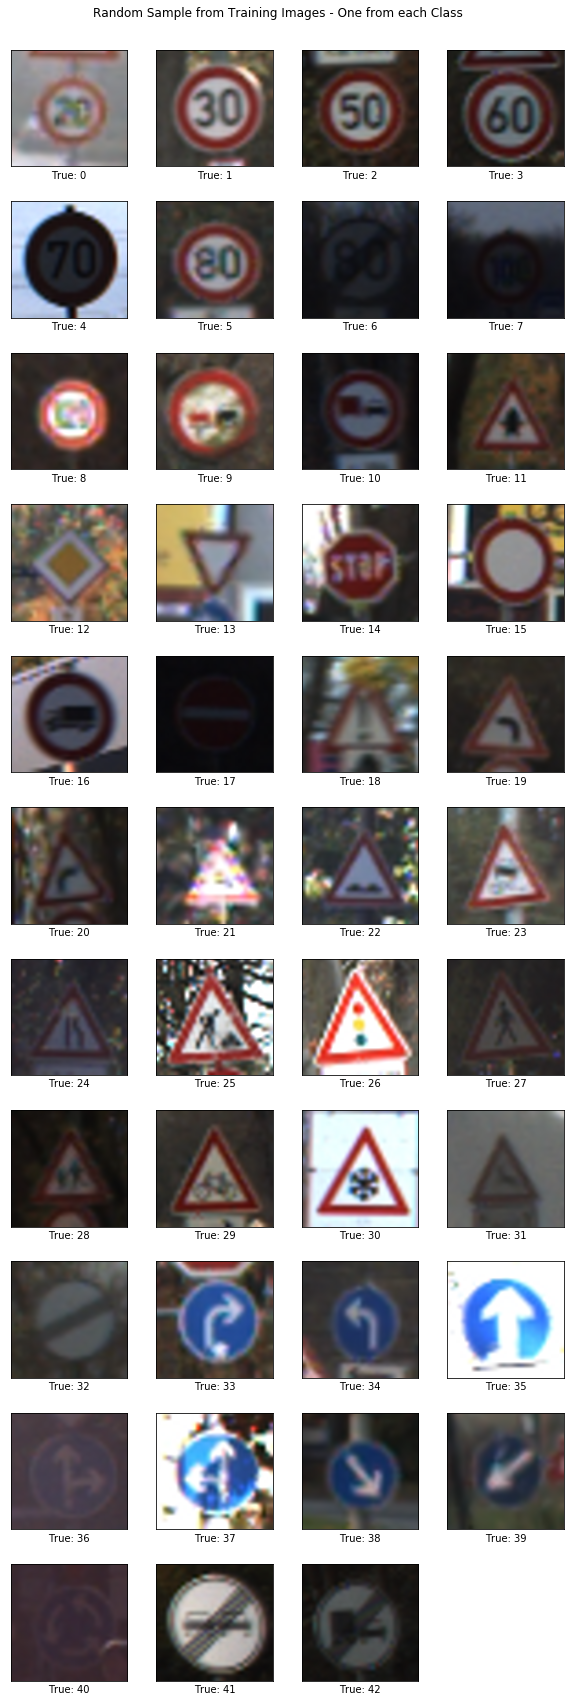

In [194]:
title = "Random Sample from Training Images - One from each Class"
plot_images(train_images, train_labels, title=title)

In [8]:
def preprocess(images, equalize_hist=True):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    preprocessed_images = np.expand_dims(np.zeros_like(images)[:, :, :, 0], 3)
    for i in range(len(images)):
        img = cv2.cvtColor(images[i], cv2.COLOR_RGB2YUV)[:, :, 0]
        if equalize_hist:
#             img = cv2.equalizeHist(img)
            img = clahe.apply(img)
        preprocessed_images[i] = np.expand_dims(img, 2)
    preprocessed_images = np.float32(preprocessed_images)
#     images -= np.mean(images, axis=0)
#     images /= (np.std(images, axis=0) + np.finfo('float32').eps)
    preprocessed_images = (preprocessed_images/127.5) - 1
    return preprocessed_images

In [9]:
train_preprocessed_images = preprocess(train_images)
test_preprocessed_images = preprocess(test_images)

In [10]:
train_preprocessed_images.shape, test_preprocessed_images.shape

((39209, 32, 32, 1), (12630, 32, 32, 1))

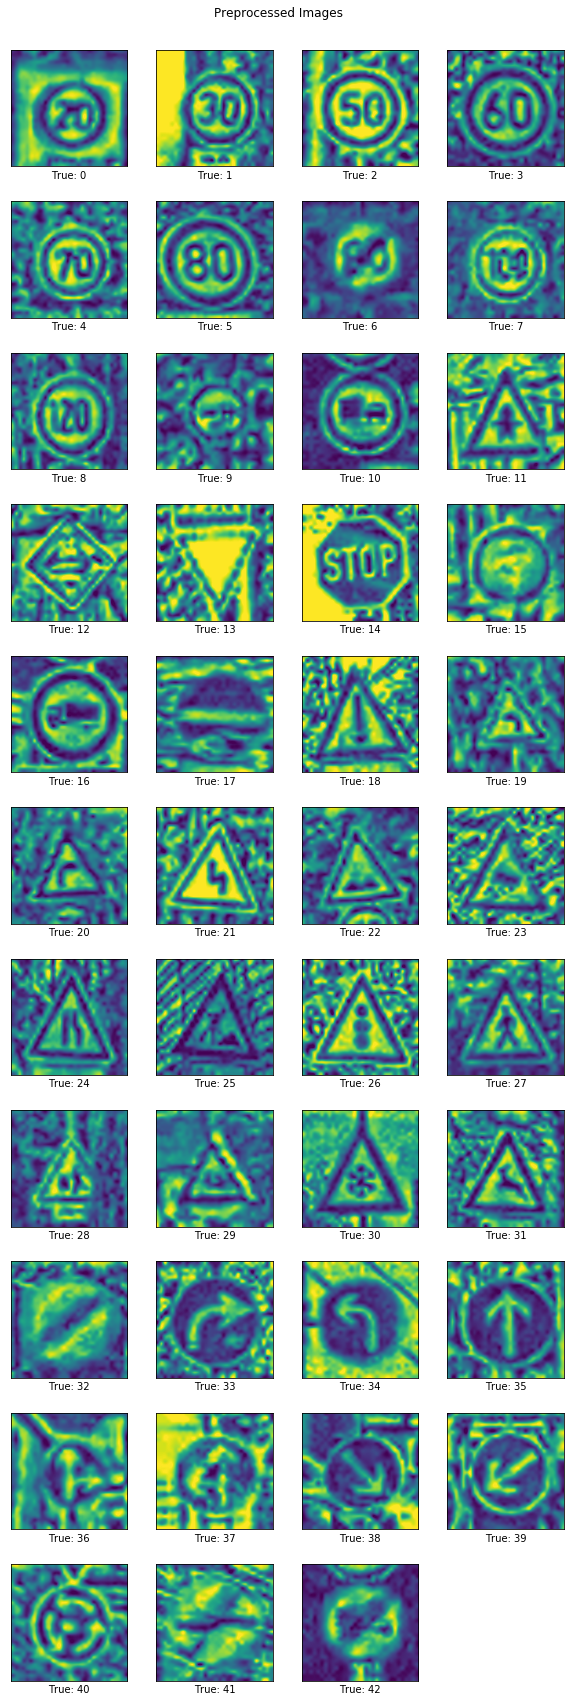

In [195]:
title = "Preprocessed Images"
plot_images(train_preprocessed_images[:, :, :, 0], train_labels, title=title)

In [12]:
def create_model(num_classes, input_shape=(32, 32, 1), lr=0.0001):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    print(model.summary())

    adam = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
input_shape = (img_h, img_w, 1)
model = create_model(num_classes=43, input_shape=input_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
__________

In [14]:
val_size = 0.15

train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=43)

x_train, x_val, y_train, y_val = train_test_split(train_preprocessed_images, train_labels_one_hot, test_size=val_size)
x_train.shape, x_val.shape

((33327, 32, 32, 1), (5882, 32, 32, 1))

In [15]:
train_generator = ImageDataGenerator(rotation_range=15., zoom_range=0.2, width_shift_range=0.1, height_shift_range=0.1)
val_generator = ImageDataGenerator()

train_generator.fit(x_train)
val_generator.fit(x_val)

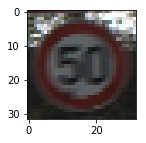

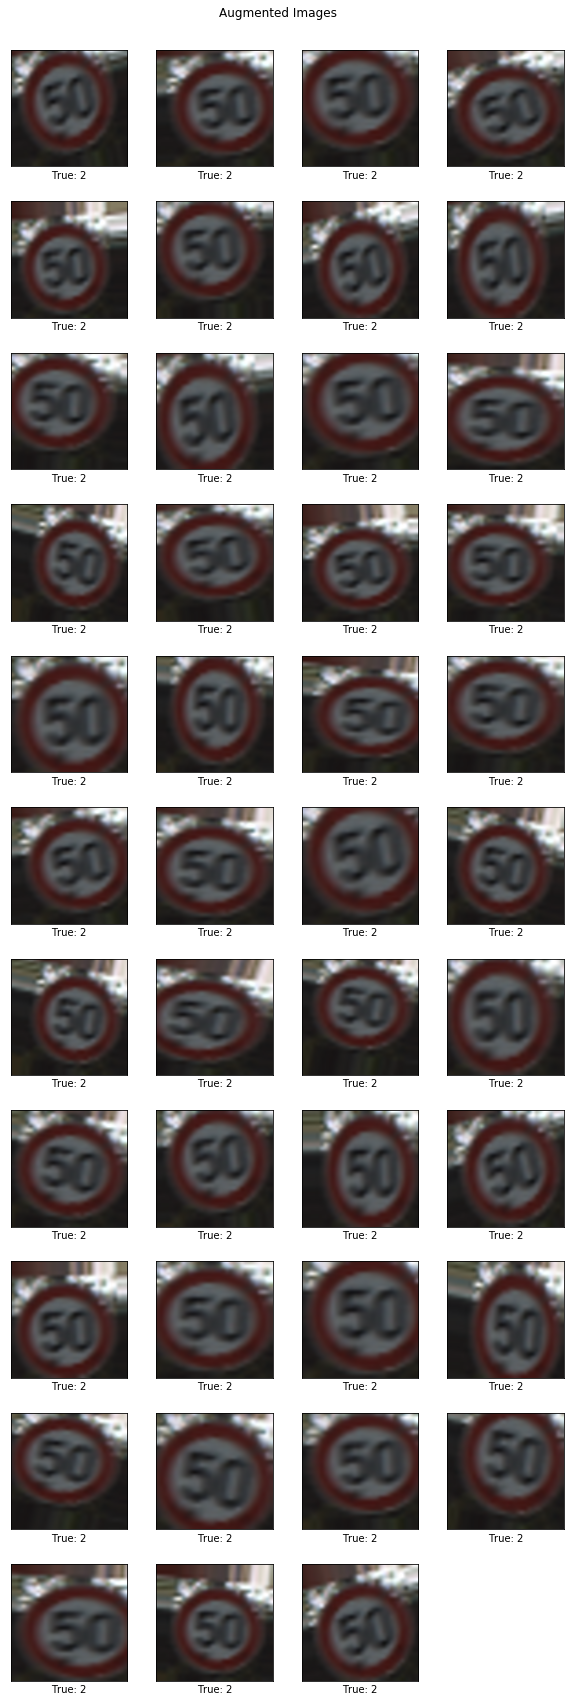

In [196]:
batch_size = 44
title = "Augmented Images"

idx = np.random.randint(len(train_images))
example_image = train_images[idx]
example_label = train_labels[idx]
plt.figure(figsize=(2, 2))
plt.imshow(example_image)

augmented_images = []
for i in range(batch_size):
    aug_img = train_generator.flow(np.expand_dims(example_image, 0), np.expand_dims(example_label, 0)).next()[0]
    augmented_images.append(np.uint8(np.squeeze(aug_img)))
plot_images(np.squeeze(augmented_images), np.repeat(example_label, batch_size), title=title, augmented=True)

In [17]:
batch_size = 64
epochs = 50
model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=len(x_train)/ batch_size, epochs=epochs, \
                    validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size), \
                    validation_steps=len(x_val)/batch_size)

Epoch 1/50
521/520 [==============================] - 15s 29ms/step - loss: 2.7202 - acc: 0.2496 - val_loss: 1.1189 - val_acc: 0.6670
Epoch 2/50
521/520 [==============================] - 10s 19ms/step - loss: 1.3600 - acc: 0.5794 - val_loss: 0.4927 - val_acc: 0.8485
Epoch 3/50
521/520 [==============================] - 10s 19ms/step - loss: 0.9207 - acc: 0.7121 - val_loss: 0.2545 - val_acc: 0.9194
Epoch 4/50
521/520 [==============================] - 10s 19ms/step - loss: 0.6776 - acc: 0.7823 - val_loss: 0.1960 - val_acc: 0.9369
Epoch 5/50
521/520 [==============================] - 10s 19ms/step - loss: 0.5238 - acc: 0.8329 - val_loss: 0.1034 - val_acc: 0.9706
Epoch 6/50
521/520 [==============================] - 10s 19ms/step - loss: 0.4296 - acc: 0.8618 - val_loss: 0.1087 - val_acc: 0.9626
Epoch 7/50
521/520 [==============================] - 10s 19ms/step - loss: 0.3652 - acc: 0.8832 - val_loss: 0.0605 - val_acc: 0.9825
Epoch 8/50
521/520 [==============================] - 10s 19ms

In [23]:
model.save(model_dir)

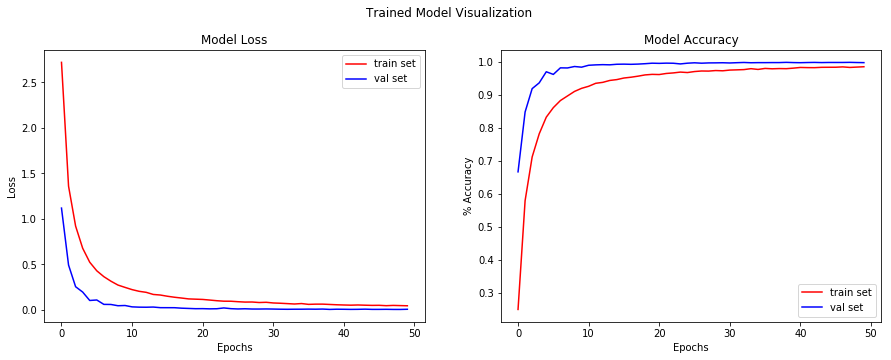

In [191]:
fig, axis = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle("Trained Model Visualization", y=1)
axis[0].plot(model.history.history['loss'], c='r')
axis[0].plot(model.history.history['val_loss'], c='b')
axis[0].set_title("Model Loss")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].legend(('train set', 'val set'))

axis[1].plot(model.history.history['acc'], c='r')
axis[1].plot(model.history.history['val_acc'], c='b')
axis[1].set_title("Model Accuracy")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("% Accuracy")
axis[1].legend(('train set', 'val set'))

plt.show()

In [83]:
predictions = model.predict(test_preprocessed_images)
predictions = np.argmax(predictions, axis=1)

In [84]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score = accuracy_score(y_true=test_labels, y_pred=predictions)
print("Accuracy on test-set: ", accuracy_score)

Accuracy on test-set:  0.9878859857482185


In [46]:
# confusion_matrix(y_true=test_labels, y_pred=predicted)

In [58]:
# np.set_printoptions(threshold=np.inf)
# print("Confusion Matrix")
# conf_matrix = confusion_matrix(y_true=test_labels, y_pred=predicted)
# for i in range(43):
#     class_name  = "({})".format(i)
#     print(*conf_matrix[i], class_name, sep=" ")

# class_numbers = ["{}".format(i) for i in range(43)]
# print("".join(class_numbers))

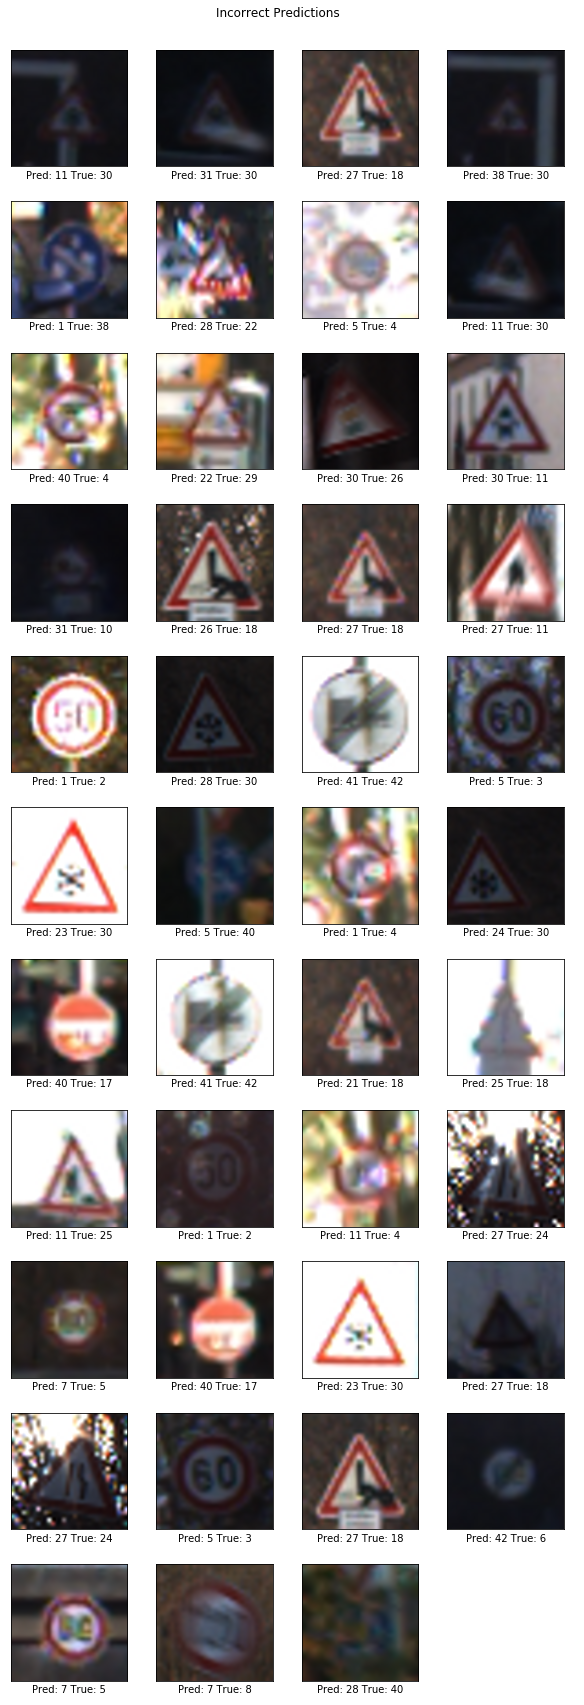

In [198]:
idx = predicted != test_labels
incorrect_pred_images = test_images[idx]
incorrect_pred_true_labels = test_labels[idx]
incorrect_pred = predictions[idx]

title = "Incorrect Predictions"
plot_images(incorrect_pred_images, incorrect_pred_true_labels, pred_classes=incorrect_pred, title=title, incorrect_pred=True)

In [122]:
per_correct = []
per_incorrect = []
classes = np.arange(0, 43)
for cls in classes:
    indices = np.squeeze(np.argwhere(test_labels == cls))
    preds = predictions[indices]
    total = len(indices)
    num_correct = corr = len(preds[preds == cls])
    num_incorrect = total - num_correct
    per_correct.append(num_correct/total)
    per_incorrect.append(num_incorrect/total)

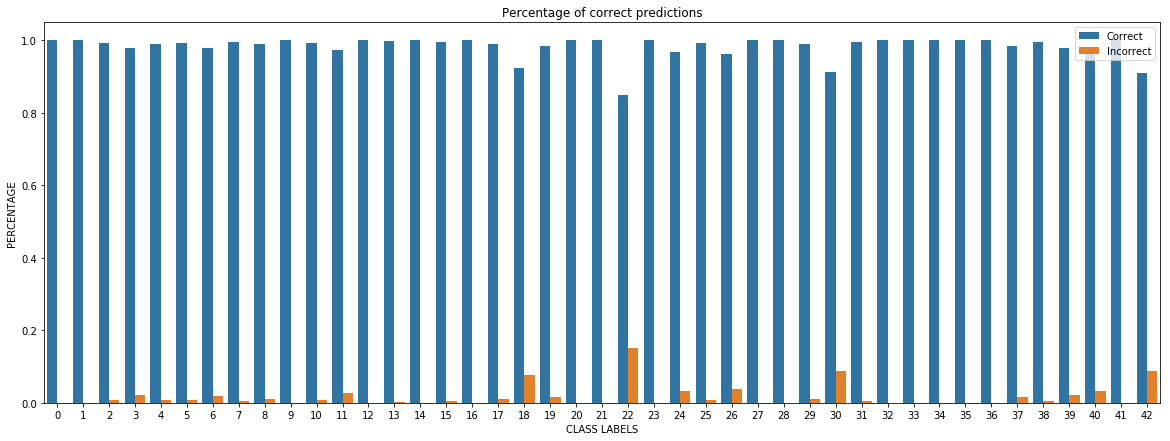

In [149]:
x = []
y = []
cat = []
for i in range(43):
    x.append(i)
    y.append(per_correct[i])
    cat.append('Correct')
    x.append(i)
    y.append(per_incorrect[i])
    cat.append('Incorrect')
    
fig, ax = plt.subplots(figsize=(20, 7))
sns.barplot(x=x, y=y, hue=cat, ax=ax)
ax.set_ylabel('PERCENTAGE')
ax.set_xlabel('CLASS LABELS')
ax.set_title('Percentage of correct predictions')
plt.show()